In [1]:
clean_up = True # if True, remove all gams related files from working folder before starting
%run stdPackages.ipynb

The file _gams_py_gdb0.gdx is still active and was not deleted.
The file _gams_py_gdb1.gdx is still active and was not deleted.
The file _gams_py_gdb4.gdx is still active and was not deleted.
The file _gams_py_gdb5.gdx is still active and was not deleted.
The file _gams_py_gdb6.gdx is still active and was not deleted.


*Load specific modules used here:*

In [2]:
os.chdir(d['py'])
import mCGE

# Load calibrated model

We can use the calibrated in one of two ways: By loading the model instance itself or by loading data and GAMS code. 

### Model instance

*Load model:*

In [3]:
name = 'WasteCGE'
M = mCGE.WasteCGE.load(os.path.join(d['data'], name)) # load model
ws = M.ws 
db0 = M.db.copy() # initial solution

We can now use the model "as usual". For instance, let us double the taxes on CO2 and solve using the relaxation method ```jSolve```: 

In [4]:
M.db['tauCO2agg'] = M.db('tauCO2agg') * 2
M.db.mergeInternal() # we do not store the gdx version of the file automatically, so we have to rewrite it here
sol = M.jSolve(3, state = 'B') # solve the model in baseline state, use 3 linear steps to get close to the solution

Look at aggregate emissions over time:

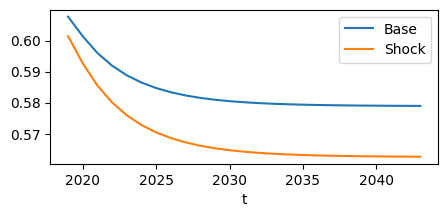

In [5]:
tPlot = M.db('t')[0:25]
adj.rc_pd(pd.DataFrame({'Base': db0('qCO2agg'), 'Shock': sol('qCO2agg')}), tPlot).plot(figsize=(5,2));

### Load code

Move all relevant gams and gdx files to the work folder where we store temporary files:

In [6]:
gms = os.path.join(d['gams'], f'{M.name}.gms') # name of gms file
gmy = os.path.join(d['gams'], f'{M.name}.gmy') # name of gmy file
gdx = os.path.join(d['data'], f'{M.db.name}.gdx') # name of database file
[shutil.copy(f, os.path.join(d['work'], os.path.basename(f))) for f in (gms,gmy,gdx)]; # create copies in work folder

To run GAMS from Python, we need a ```GamsWorkspace```. As we already have one open from above (ws), we just use that here. Otherwise, the following cell opens initializes a new one that works in the designated work folder:

In [7]:
# ws = gams.GamsWorkspace(working_directory = d['work']

Create ```GamsJob``` from file and run (this time, we haven't added any shocks to the data):

In [8]:
job = ws.add_job_from_file(os.path.join(d['work'], os.path.basename(gms)))
job.run() # run model

We can extract solution using:

In [9]:
soldb = GpyDB(job.out_db, ws = ws)

Now, we can similarly access variables e.g. capital stock in the energy sector:

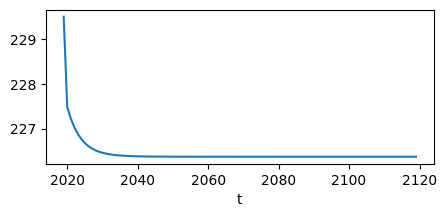

In [19]:
soldb('qD').xs(('Energy','K'),level=('s','n')).plot(figsize=(5,2));